In [ ]:
# Importing libraries and getting access to google drive
from google.colab import drive
drive.mount('/content/drive')
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, jaccard_score
from tqdm import tqdm
import matplotlib.pyplot as plt

Mounted at /content/drive


In [ ]:
# Defining path of dataset
base_path = '/content/drive/MyDrive/Binary masks'

train_image_path = os.path.join(base_path, 'train/images')
train_mask_path = os.path.join(base_path, 'train/masks')

valid_image_path = os.path.join(base_path, 'valid/images')
valid_mask_path = os.path.join(base_path, 'valid/masks')

test_image_path = os.path.join(base_path, 'test/images')
test_mask_path = os.path.join(base_path, 'test/masks')

In [ ]:
# Setting Image Size, Batch Size and Number of Epochs
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 8
EPOCHS = 50

In [ ]:
# Defining function to calculate dice Coefficient
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

In [ ]:
# Defining function to calculate IOU Coefficient
def iou_coef(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Binarize predictions

    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3]) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return tf.reduce_mean(iou)

In [ ]:
# Loading dataset and preprocessing images for training on U-Net
def load_dataset(image_dir, mask_dir):
    images = []
    masks = []

    for img_filename in sorted(os.listdir(image_dir)):
        # Construct full path for image
        image_path = os.path.join(image_dir, img_filename)

        # Construct corresponding mask filename
        base_name = os.path.splitext(img_filename)[0]
        mask_filename = f"{base_name}_mask.png"
        mask_path = os.path.join(mask_dir, mask_filename)

        # Skip if corresponding mask not found
        if not os.path.exists(mask_path):
            print(f"Mask not found for image: {img_filename}")
            continue

        # Read and process image
        img = cv2.imread(image_path)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        img = img / 255.0

        # Read and process mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
        mask = (mask > 127).astype(np.float32)

        images.append(img)
        masks.append(np.expand_dims(mask, axis=-1))

    return np.array(images), np.array(masks)

In [ ]:
# Defining function to calculate Dice Loss and IOU Loss
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
    return 1 - dice

def iou_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return 1 - iou

In [ ]:
# Defining combined loss function which is the sum of Binary Cross-Entropy loss, Dice Loss and IOU loss
def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred) + iou_loss(y_true, y_pred)

In [ ]:
# Defining U-Net model
def build_unet():
    inputs = layers.Input((IMG_HEIGHT, IMG_WIDTH, 3))

    # Encoder

    # Block 1
    c1 = layers.Conv2D(64, 3, padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Activation('relu')(c1)

    c1 = layers.Conv2D(64, 3, padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Activation('relu')(c1)

    p1 = layers.MaxPooling2D()(c1)

    # Block 2
    c2 = layers.Conv2D(128, 3, padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Activation('relu')(c2)

    c2 = layers.Conv2D(128, 3, padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Activation('relu')(c2)

    p2 = layers.MaxPooling2D()(c2)

    # Block 3
    c3 = layers.Conv2D(256, 3, padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Activation('relu')(c3)

    c3 = layers.Conv2D(256, 3, padding='same')(c3)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Activation('relu')(c3)

    p3 = layers.MaxPooling2D()(c3)

    # Bottleneck
    b = layers.Conv2D(512, 3, padding='same')(p3)
    b = layers.BatchNormalization()(b)
    b = layers.Activation('relu')(b)

    b = layers.Conv2D(512, 3, padding='same')(b)
    b = layers.BatchNormalization()(b)
    b = layers.Activation('relu')(b)


    # Decoder
    # Decoder Block 1 (upsampling from bottleneck)
    u3 = layers.UpSampling2D()(b)
    u3 = layers.Concatenate()([u3, c3])

    c4 = layers.Conv2D(256, 3, padding='same')(u3)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Activation('relu')(c4)

    c4 = layers.Conv2D(256, 3, padding='same')(c4)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Activation('relu')(c4)

    # Decoder Block 2
    u2 = layers.UpSampling2D()(c4)
    u2 = layers.Concatenate()([u2, c2])

    c5 = layers.Conv2D(128, 3, padding='same')(u2)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Activation('relu')(c5)

    c5 = layers.Conv2D(128, 3, padding='same')(c5)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Activation('relu')(c5)

    # Decoder Block 3
    u1 = layers.UpSampling2D()(c5)
    u1 = layers.Concatenate()([u1, c1])

    c6 = layers.Conv2D(64, 3, padding='same')(u1)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Activation('relu')(c6)

    c6 = layers.Conv2D(64, 3, padding='same')(c6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Activation('relu')(c6)

    # Output Layer
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c6)

    model = models.Model(inputs, outputs)
    return model

model = build_unet()
model.compile(optimizer='adam', loss=combined_loss, metrics=['accuracy',dice_coef,iou_coef])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]  

 Total params: 7,794,177 (29.73 MB)

 Trainable params: 7,788,545 (29.71 MB)

 Non-trainable params: 5,632 (22.00 KB)

In [ ]:
train_images, train_masks = load_dataset(train_image_path, train_mask_path)
valid_images, valid_masks = load_dataset(valid_image_path, valid_mask_path)
test_images, test_masks = load_dataset(test_image_path, test_mask_path)

In [ ]:
# Set checkpoint when validation loss improves
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "best_model.h5",
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

# Stop training early if validation loss doesn't improve
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate when validation loss plateaus
reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# === Combine all callbacks ===
callbacks = [checkpoint_cb, early_stopping_cb, reduce_lr_cb]

In [ ]:
# Train the U-Net
history = model.fit(
    train_images, train_masks,
    validation_data=(valid_images, valid_masks),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.8611 - dice_coef: 0.7163 - iou_coef: 0.6466 - loss: 1.0681
Epoch 1: val_loss improved from inf to 2.32074, saving model to best_model.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 84s 605ms/step - accuracy: 0.8617 - dice_coef: 0.7177 - iou_coef: 0.6480 - loss: 1.0638 - val_accuracy: 0.7689 - val_dice_coef: 0.6966 - val_iou_coef: 0.5538 - val_loss: 2.3207 - learning_rate: 0.0010
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.9245 - dice_coef: 0.8484 - iou_coef: 0.7857 - loss: 0.6392
Epoch 2: val_loss did not improve from 2.32074
52/52 ━━━━━━━━━━━━━━━━━━━━ 30s 401ms/step - accuracy: 0.9246 - dice_coef: 0.8485 - iou_coef: 0.7858 - loss: 0.6385 - val_accuracy: 0.7043 - val_dice_coef: 0.0390 - val_iou_coef: 0.0073 - val_loss: 3.2239 - learning_rate: 0.0010
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.9389 - dice_coef: 0.8751 - iou_coef: 0.8110 - loss: 0.5369
Epoch 3: val_loss did not improve from 2.32074
52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 394ms/step - accuracy: 0.9389 - dice_coef: 0.8752 - iou_coef: 0.8111 - loss: 0.5366 - val_accuracy: 0.7129 - val_dice_coef: 0.0795 - val_iou_coef: 0.0361 - val_loss: 3.5

52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 401ms/step - accuracy: 0.9483 - dice_coef: 0.8958 - iou_coef: 0.8403 - loss: 0.4491 - val_accuracy: 0.8217 - val_dice_coef: 0.5686 - val_iou_coef: 0.4053 - val_loss: 1.9058 - learning_rate: 0.0010
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9488 - dice_coef: 0.9008 - iou_coef: 0.8444 - loss: 0.4355
Epoch 5: val_loss improved from 1.90578 to 1.29273, saving model to best_model.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 408ms/step - accuracy: 0.9488 - dice_coef: 0.9008 - iou_coef: 0.8445 - loss: 0.4352 - val_accuracy: 0.8763 - val_dice_coef: 0.7445 - val_iou_coef: 0.6070 - val_loss: 1.2927 - learning_rate: 0.0010
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.9547 - dice_coef: 0.9115 - iou_coef: 0.8589 - loss: 0.3882
Epoch 6: val_loss did not improve from 1.29273
52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 399ms/step - accuracy: 0.9548 - dice_coef: 0.9116 - iou_coef: 0.8590 - loss: 0.3878 - val_accuracy: 0.7179 - val_dice_coef: 0.1071 - val_iou_coef: 0.0545 - val_loss: 3.5840 - learning_rate: 0.0010
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9549 - dice_coef: 0.9126 - iou_coef: 0.8587 - loss: 0.3855
Epoch 7: val_loss did not improve from 1.29273
52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 398ms/step - accuracy: 0.9549 - dice_coef: 0.9126 - iou_coef: 0.8587 - loss: 0.3855 - val_accuracy: 0.8185 - val_dice_coef: 0.5705 - val_iou_coef: 0.4207 - val_loss: 2.1

52/52 ━━━━━━━━━━━━━━━━━━━━ 42s 414ms/step - accuracy: 0.9626 - dice_coef: 0.9274 - iou_coef: 0.8795 - loss: 0.3236 - val_accuracy: 0.9236 - val_dice_coef: 0.8566 - val_iou_coef: 0.7714 - val_loss: 0.7346 - learning_rate: 0.0010
Epoch 10/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.9647 - dice_coef: 0.9298 - iou_coef: 0.8866 - loss: 0.3066
Epoch 10: val_loss improved from 0.73459 to 0.47082, saving model to best_model.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 40s 402ms/step - accuracy: 0.9647 - dice_coef: 0.9298 - iou_coef: 0.8866 - loss: 0.3068 - val_accuracy: 0.9458 - val_dice_coef: 0.8998 - val_iou_coef: 0.8363 - val_loss: 0.4708 - learning_rate: 0.0010
Epoch 11/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.9626 - dice_coef: 0.9269 - iou_coef: 0.8783 - loss: 0.3267
Epoch 11: val_loss did not improve from 0.47082
52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 395ms/step - accuracy: 0.9626 - dice_coef: 0.9269 - iou_coef: 0.8783 - loss: 0.3270 - val_accuracy: 0.8737 - val_dice_coef: 0.7418 - val_iou_coef: 0.6136 - val_loss: 1.4124 - learning_rate: 0.0010
Epoch 12/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.9605 - dice_coef: 0.9210 - iou_coef: 0.8724 - loss: 0.3458
Epoch 12: val_loss did not improve from 0.47082
52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 403ms/step - accuracy: 0.9605 - dice_coef: 0.9210 - iou_coef: 0.8724 - loss: 0.3457 - val_accuracy: 0.9409 - val_dice_coef: 0.8819 - val_iou_coef: 0.8136 - val_loss:

52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 405ms/step - accuracy: 0.9688 - dice_coef: 0.9388 - iou_coef: 0.8980 - loss: 0.2716 - val_accuracy: 0.9600 - val_dice_coef: 0.9262 - val_iou_coef: 0.8746 - val_loss: 0.3326 - learning_rate: 0.0010
Epoch 15/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.9689 - dice_coef: 0.9373 - iou_coef: 0.8953 - loss: 0.2765
Epoch 15: val_loss did not improve from 0.33255
52/52 ━━━━━━━━━━━━━━━━━━━━ 40s 394ms/step - accuracy: 0.9689 - dice_coef: 0.9372 - iou_coef: 0.8953 - loss: 0.2767 - val_accuracy: 0.9414 - val_dice_coef: 0.8983 - val_iou_coef: 0.8307 - val_loss: 0.4977 - learning_rate: 0.0010
Epoch 16/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.9675 - dice_coef: 0.9360 - iou_coef: 0.8934 - loss: 0.2829
Epoch 16: val_loss did not improve from 0.33255
52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 395ms/step - accuracy: 0.9674 - dice_coef: 0.9360 - iou_coef: 0.8933 - loss: 0.2831 - val_accuracy: 0.9310 - val_dice_coef: 0.8802 - val_iou_coef: 0.7996 - val_loss:

52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 407ms/step - accuracy: 0.9756 - dice_coef: 0.9523 - iou_coef: 0.9181 - loss: 0.2107 - val_accuracy: 0.9725 - val_dice_coef: 0.9485 - val_iou_coef: 0.9091 - val_loss: 0.2351 - learning_rate: 5.0000e-04
Epoch 23/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9777 - dice_coef: 0.9568 - iou_coef: 0.9246 - loss: 0.1918
Epoch 23: val_loss did not improve from 0.23507
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 401ms/step - accuracy: 0.9777 - dice_coef: 0.9568 - iou_coef: 0.9246 - loss: 0.1920 - val_accuracy: 0.9680 - val_dice_coef: 0.9406 - val_iou_coef: 0.8978 - val_loss: 0.2772 - learning_rate: 5.0000e-04
Epoch 24/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.9754 - dice_coef: 0.9529 - iou_coef: 0.9191 - loss: 0.2105
Epoch 24: val_loss did not improve from 0.23507
52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 401ms/step - accuracy: 0.9754 - dice_coef: 0.9529 - iou_coef: 0.9191 - loss: 0.2106 - val_accuracy: 0.9392 - val_dice_coef: 0.8835 - val_iou_coef: 0.8122 - v

52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 413ms/step - accuracy: 0.9785 - dice_coef: 0.9578 - iou_coef: 0.9264 - loss: 0.1877 - val_accuracy: 0.9728 - val_dice_coef: 0.9475 - val_iou_coef: 0.9107 - val_loss: 0.2339 - learning_rate: 5.0000e-04
Epoch 28/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9782 - dice_coef: 0.9560 - iou_coef: 0.9238 - loss: 0.1933
Epoch 28: val_loss did not improve from 0.23394
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 408ms/step - accuracy: 0.9781 - dice_coef: 0.9560 - iou_coef: 0.9237 - loss: 0.1934 - val_accuracy: 0.9685 - val_dice_coef: 0.9392 - val_iou_coef: 0.8955 - val_loss: 0.2749 - learning_rate: 5.0000e-04
Epoch 29/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.9771 - dice_coef: 0.9556 - iou_coef: 0.9235 - loss: 0.1967
Epoch 29: val_loss improved from 0.23394 to 0.21838, saving model to best_model.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 400ms/step - accuracy: 0.9771 - dice_coef: 0.9556 - iou_coef: 0.9235 - loss: 0.1966 - val_accuracy: 0.9744 - val_dice_coef: 0.9525 - val_iou_coef: 0.9146 - val_loss: 0.2184 - learning_rate: 5.0000e-04
Epoch 30/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.9788 - dice_coef: 0.9589 - iou_coef: 0.9282 - loss: 0.1838
Epoch 30: val_loss did not improve from 0.21838
52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 406ms/step - accuracy: 0.9788 - dice_coef: 0.9589 - iou_coef: 0.9282 - loss: 0.1837 - val_accuracy: 0.9737 - val_dice_coef: 0.9504 - val_iou_coef: 0.9138 - val_loss: 0.2218 - learning_rate: 5.0000e-04
Epoch 31/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.9782 - dice_coef: 0.9574 - iou_coef: 0.9263 - loss: 0.1900
Epoch 31: val_loss did not improve from 0.21838
52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 403ms/step - accuracy: 0.9782 - dice_coef: 0.9574 - iou_coef: 0.9263 - loss: 0.1900 - val_accuracy: 0.9707 - val_dice_coef: 0.9467 - val_iou_coef: 0.9051 - v

52/52 ━━━━━━━━━━━━━━━━━━━━ 42s 412ms/step - accuracy: 0.9800 - dice_coef: 0.9599 - iou_coef: 0.9296 - loss: 0.1759 - val_accuracy: 0.9752 - val_dice_coef: 0.9540 - val_iou_coef: 0.9182 - val_loss: 0.2099 - learning_rate: 5.0000e-04
Epoch 34/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.9786 - dice_coef: 0.9587 - iou_coef: 0.9283 - loss: 0.1841
Epoch 34: val_loss did not improve from 0.20989
52/52 ━━━━━━━━━━━━━━━━━━━━ 40s 404ms/step - accuracy: 0.9786 - dice_coef: 0.9587 - iou_coef: 0.9283 - loss: 0.1841 - val_accuracy: 0.9714 - val_dice_coef: 0.9444 - val_iou_coef: 0.9043 - val_loss: 0.2493 - learning_rate: 5.0000e-04
Epoch 35/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.9804 - dice_coef: 0.9609 - iou_coef: 0.9320 - loss: 0.1718
Epoch 35: val_loss did not improve from 0.20989
52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 404ms/step - accuracy: 0.9804 - dice_coef: 0.9610 - iou_coef: 0.9320 - loss: 0.1718 - val_accuracy: 0.9693 - val_dice_coef: 0.9411 - val_iou_coef: 0.9000 - v

52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 411ms/step - accuracy: 0.9819 - dice_coef: 0.9642 - iou_coef: 0.9369 - loss: 0.1583 - val_accuracy: 0.9764 - val_dice_coef: 0.9559 - val_iou_coef: 0.9210 - val_loss: 0.2018 - learning_rate: 2.5000e-04
Epoch 40/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.9821 - dice_coef: 0.9652 - iou_coef: 0.9383 - loss: 0.1541
Epoch 40: val_loss did not improve from 0.20184
52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 403ms/step - accuracy: 0.9821 - dice_coef: 0.9652 - iou_coef: 0.9383 - loss: 0.1541 - val_accuracy: 0.9760 - val_dice_coef: 0.9554 - val_iou_coef: 0.9202 - val_loss: 0.2046 - learning_rate: 2.5000e-04
Epoch 41/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.9824 - dice_coef: 0.9658 - iou_coef: 0.9399 - loss: 0.1516
Epoch 41: val_loss did not improve from 0.20184
52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 396ms/step - accuracy: 0.9824 - dice_coef: 0.9658 - iou_coef: 0.9399 - loss: 0.1517 - val_accuracy: 0.9746 - val_dice_coef: 0.9538 - val_iou_coef: 0.9166 - v

52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 398ms/step - accuracy: 0.9838 - dice_coef: 0.9684 - iou_coef: 0.9437 - loss: 0.1399 - val_accuracy: 0.9766 - val_dice_coef: 0.9562 - val_iou_coef: 0.9213 - val_loss: 0.2010 - learning_rate: 2.5000e-04
Epoch 45/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.9834 - dice_coef: 0.9674 - iou_coef: 0.9425 - loss: 0.1449
Epoch 45: val_loss improved from 0.20095 to 0.20031, saving model to best_model.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 406ms/step - accuracy: 0.9834 - dice_coef: 0.9674 - iou_coef: 0.9425 - loss: 0.1448 - val_accuracy: 0.9768 - val_dice_coef: 0.9562 - val_iou_coef: 0.9220 - val_loss: 0.2003 - learning_rate: 2.5000e-04
Epoch 46/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.9840 - dice_coef: 0.9688 - iou_coef: 0.9437 - loss: 0.1378
Epoch 46: val_loss did not improve from 0.20031
52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 401ms/step - accuracy: 0.9840 - dice_coef: 0.9688 - iou_coef: 0.9437 - loss: 0.1379 - val_accuracy: 0.9764 - val_dice_coef: 0.9560 - val_iou_coef: 0.9210 - val_loss: 0.2039 - learning_rate: 2.5000e-04
Epoch 47/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9840 - dice_coef: 0.9683 - iou_coef: 0.9435 - loss: 0.1395
Epoch 47: val_loss did not improve from 0.20031
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 409ms/step - accuracy: 0.9840 - dice_coef: 0.9683 - iou_coef: 0.9436 - loss: 0.1395 - val_accuracy: 0.9754 - val_dice_coef: 0.9552 - val_iou_coef: 0.9188 - v

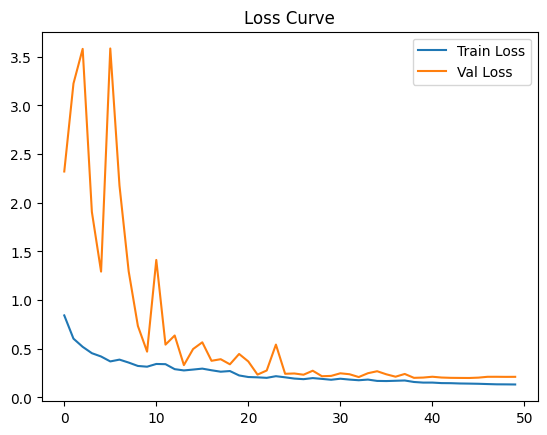

In [ ]:
# Plot train loss vs validaion loss curve
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Curve")
plt.show()

In [ ]:
# Displaying accuracy and IOU on test data
preds = model.predict(test_images)
preds = (preds > 0.5).astype(np.uint8)

# Flatten arrays for metric calculation
y_true = test_masks.flatten()
y_pred = preds.flatten()

acc = accuracy_score(y_true, y_pred)
iou = jaccard_score(y_true, y_pred)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test IoU: {iou:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 51s 20s/step
Test Accuracy: 0.9777
Test IoU: 0.9257


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


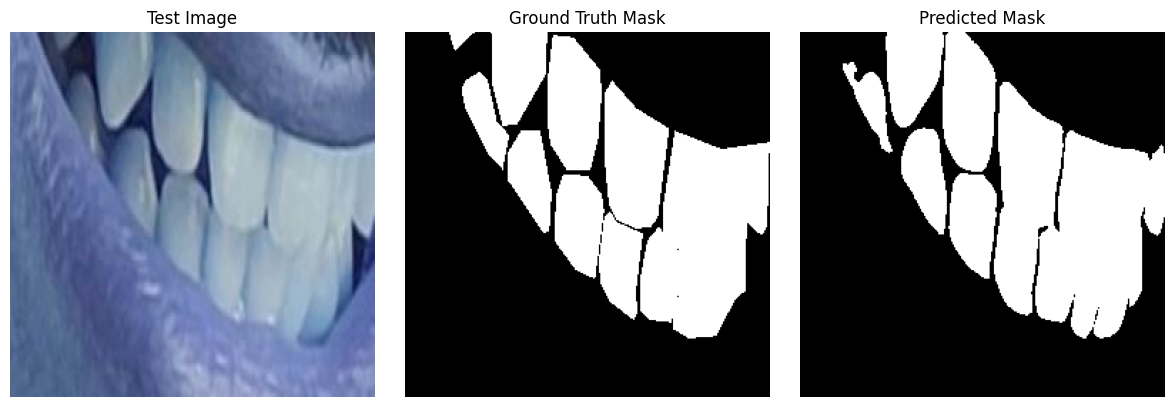

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


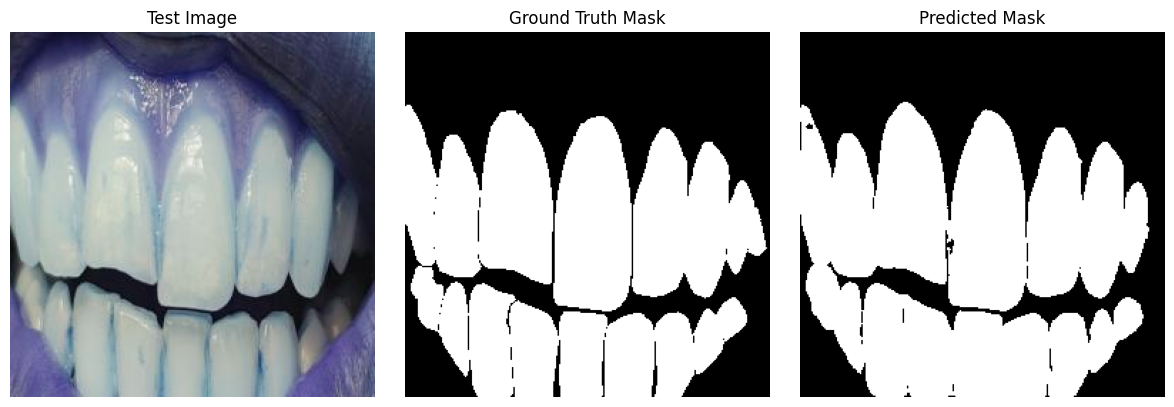

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


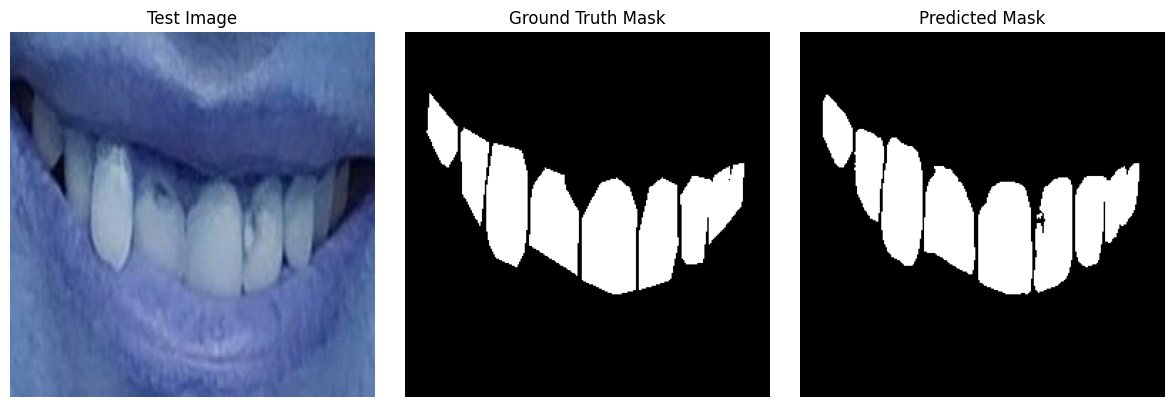

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


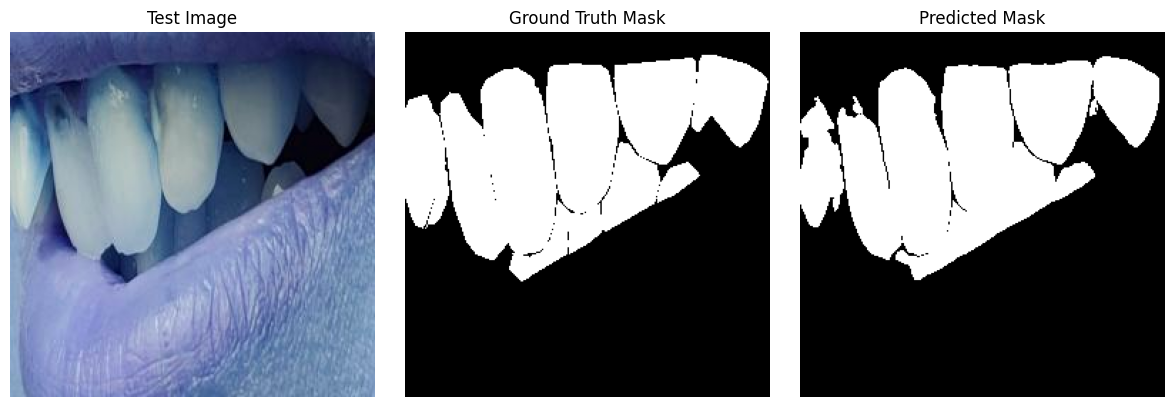

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


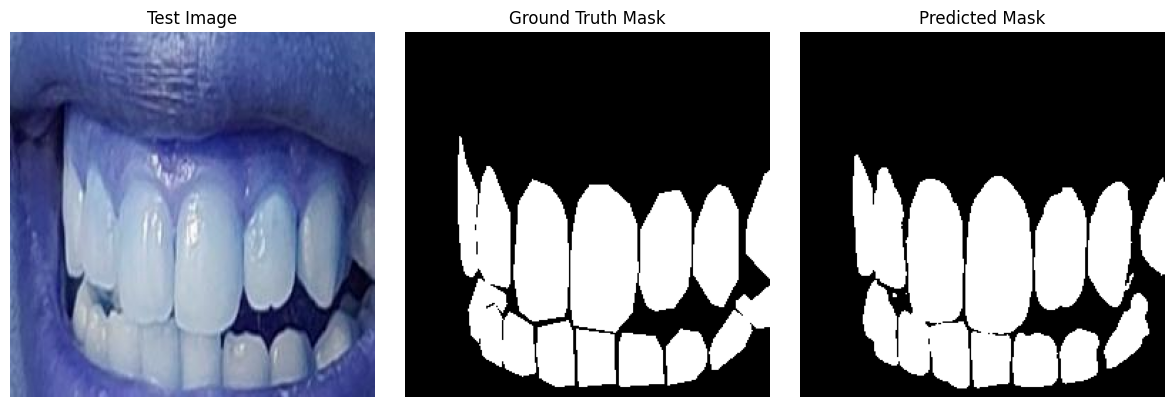

In [ ]:
import random
# Display 5 random images of actual masks and predicted masks
def display_predictions(model, test_images, test_masks, num_samples=5):
    indices = random.sample(range(len(test_images)), num_samples)

    for i in indices:
        image = test_images[i]
        true_mask = test_masks[i].squeeze()
        pred_mask = model.predict(np.expand_dims(image, axis=0))[0].squeeze()

        # Threshold the predicted mask
        pred_mask = (pred_mask > 0.5).astype(np.uint8)

        # Plot
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Test Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(true_mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

# Show predictions
display_predictions(model, test_images, test_masks, num_samples=5)


In [ ]:
# Saving the model in google drive
model_dir = "/content/drive/MyDrive/tf_models"
import os
os.makedirs(model_dir, exist_ok=True)
# Saving the model in google drive
model.save(os.path.join(model_dir, 'Dental_mkIII.h5'))
model.save(os.path.join(model_dir, 'Dental_mkIII.keras'))